# Car crash Severity Prediction

In this notebook, we used PennDOT data to predict car crash severity. We aimed to predict the severity level of  car crashes that happen in Pittsburgh. We think this prediction may help to prevent potential severe car crashes if people are noticed that some areas are more likely to have incidents with severe injury. 

In [3]:
import base64, ckanapi, collections, json, wget, requests, time, zipfile, pyglet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd

from itertools import product
from pathlib import Path
from pprint import pprint
from scipy import stats
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from shapely.geometry import Point
from requests.auth import HTTPBasicAuth
%matplotlib inline

## Load Data

We used The Western Pennsylvania Regional Data Center Cumulative Crash Data (2004-2018) (WPRDC) as the training data set to predict car crash severity and PennDOT Crash Download Map as the testing data set.

In [24]:
if not Path('all-crashes-2004-2018.csv.zip').exists():
    wget.download("https://data.wprdc.org/dataset/3130f583-9499-472b-bb5a-f63a6ff6059a/resource/ec578660-2d3f-489d-9ba1-af0ebfc3b140/download/all-crashes-2004-2018.csv.zip")

df_io = pd.read_csv('all-crashes-2004-2018.csv.zip').reset_index()
print("The Western Pennsylvania Regional Data Center Cumulative Crash Data\n")
print(df_io.head())
print("\n")

if not Path('CRASH_V_2018.csv').exists():
    if not Path('Statewide_2018.zip').exists():
        wget.download("https://www.arcgis.com/sharing/rest/content/items/2b929d2b47694610bfc8cc1d8aab2f07/data")
    zipfile.ZipFile('Statewide_2018.zip', 'r').extractall()

df_counties = pd.read_csv('CRASH_V_2018.csv').reset_index()
print("PennDOT Crash Download Map")
df_counties.head()


# df_counties = df_counties[combined + label]

The Western Pennsylvania Regional Data Center Cumulative Crash Data

   index   CRASH_CRN  DISTRICT  CRASH_COUNTY  MUNICIPALITY POLICE_AGCY  \
0      0  2004000001        11             2          2454       02454   
1      1  2004000010        11             2          2440       02440   
2      2  2004000016        11             2          2203       02203   
3      3  2004000022        11             2          2404       02404   
4      4  2004000030        11             2          2419       02419   

   CRASH_YEAR  CRASH_MONTH  DAY_OF_WEEK  TIME_OF_DAY  ...  LANE_COUNT  \
0        2004            1            5        257.0  ...         2.0   
1        2004            1            5       1027.0  ...         2.0   
2        2004            1            5       1839.0  ...         2.0   
3        2004            1            6        914.0  ...         2.0   
4        2004            1            5       2230.0  ...         2.0   

   RDWY_ORIENT  ROAD_OWNER  ROUTE  SPEED_LIMIT 

,index,CRN,DISTRICT,COUNTY,MUNICIPALITY,POLICE_AGCY,CRASH_YEAR,CRASH_MONTH,DAY_OF_WEEK,TIME_OF_DAY,...,PED_DEATH_COUNT,PED_MAJ_INJ_COUNT,MAX_SEVERITY_LEVEL,COMM_VEH_COUNT,DEC_LAT,DEC_LONG,RDWY_SURF_TYPE_CD,COUNTY_NAME,MUNICIPALITY_NAME,COUNTY_YEAR
0,0,2018005696,8,36,36202,68T06,2018,1,3,0810,...,0,0,0,0,40.2356,-76.0459,,Lancaster,Brecknock Twp,CRASH_2018_Lancaster
1,1,2018000319,2,24,24301,24301,2018,1,2,1624,...,0,0,0,0,41.4377,-78.5842,,Elk,Saint Marys City,CRASH_2018_Elk
2,2,2018005742,6,23,23111,23111,2018,1,5,2055,...,0,0,8,0,39.9637,-75.2826,,Delaware,Upper Darby Twp,CRASH_2018_Delaware
3,3,2018005777,5,48,48301,48501,2018,1,6,0500,...,0,0,3,0,40.6022,-75.3741,,Northampton,Bethlehem City,CRASH_2018_Northampton
4,4,2018003363,9,7,7201,68G01,2018,1,3,0118,...,0,0,0,0,40.4703,-78.5370,,Blair,Allegheny Twp,CRASH_2018_Blair


## Splitting Data, Picking Features

The following variables will be used. Three models will be developed: one only studies the effects of environment static factor, one studies dynamic factors, and one for both factors.

Static factors, as features, would be the features that are affixed to the time and location.

Dynamic factors, as features, would just be how many vehicles are involved in the crash, and whether any special vehicles were involved.

We considered 5 labels, where PERSON_COUNT, FATAL_COUNT, INJURY_COUNT would be in discrete heads of people, and MAX_SEVERITY_LEVEL and MAJOR_INJURY were number labels assigned to a map.

MAX_SEVERITY_LEVEL: Injury severity level of the crash

0 - Not injured

1 - Killed

2 - Major injury

3 - Moderate injury

4 - Minor injury

8 - Injury/ Unknown Severity

9 - Unknown

MAJOR_INJURY: At least 1 Person Sustained a Major Injury

0 = No

1 = Yes


In [5]:
static = ['ROAD_CONDITION', 'LANE_CLOSED', 'TIME_OF_DAY', 'SPEED_LIMIT', 'ILLUMINATION']
dynamic = ['MOTORCYCLE_COUNT', 'HEAVY_TRUCK_COUNT', 'HAZARDOUS_TRUCK', 'AUTOMOBILE_COUNT', 'SCH_BUS_IND', 'WEATHER']
label = ['PERSON_COUNT', 'FATAL_COUNT', 'INJURY_COUNT', 'MAX_SEVERITY_LEVEL', 'MAJOR_INJURY']
categorical = ['ROAD_CONDITION', 'LANE_CLOSED', 'ILLUMINATION', 'HAZARDOUS_TRUCK', 'SCH_BUS_IND', 'WEATHER']
gaussian = ['TIME_OF_DAY', 'SPEED_LIMIT', 'MOTORCYCLE_COUNT', 'HEAVY_TRUCK_COUNT', 'AUTOMOBILE_COUNT']
combined = static + dynamic

## Data Preprocessing

We did some data cleaning on some of the features (SCH_BUS_IND, ROAD_CONDITION, ILLUMINATION, WEATHER, TIME_OF_DAY). Converting these features into integers and dropping those rows with nan, we transformed the dataset so that it was compatible with our Naive Bayes Model below. 

In [6]:
#clean sch_bus_ind y/n to integer 0,1

def type_boolean(c):
    if c == "Y": return 1
    elif c == "N": return 0
    # elif c == "nan": return np.nan
    else:
        return np.nan
    # raise ValueError(c)

def ROAD_CONDITION(c): # 8 is other 9 is unknown, 1,7->2, 3->4, 4->3, 5,6->5, 2,8,9->nan
    if c == 1 or c == 7:
        return 2
    elif c == 3:
        return 4
    elif c == 4:
        return 3
    elif c == 5 or c == 6:
        return 5
    else:
        return np.nan

def ILLUMINATION(c):
    if c <= 6:
        return c
    else:
        return np.nan
    
def WEATHER(c):
    if c <= 7:
        return c
    else:
        return np.nan
    
def TIME(c): # extract only the hour
    if c <= 2500:
        return c // 100
    else:
        return np.nan

# clean data
df_io['SCH_BUS_IND'] = df_io['SCH_BUS_IND'].apply(type_boolean)
df_io['ROAD_CONDITION'] = df_io['ROAD_CONDITION'].apply(ROAD_CONDITION)
df_io['ILLUMINATION'] = df_io['ILLUMINATION'].apply(ILLUMINATION)
df_io['WEATHER'] = df_io['WEATHER'].apply(WEATHER)
df_io['TIME_OF_DAY'] = df_io['TIME_OF_DAY'].apply(TIME)

## Data Visualization

To better understand this car crashing dataset and get some insights into the correlation between different variables, data visualization is performed by developing curve, scatterplot matrix and 3D regional plot. 

### Car crash over years

The WPRDC data contains data from 2004 to 2018, which provides data with duration long enough that could allow observe the trend over years. In the section below, total number of crashes, total injuries and total number of alcohol related crashes are ploted against the year. 

As shown in the figures, the number of crashes fluctuates between yeras, but the total number of injuries decreases, as well as the number of alcohol related events. This indicates that the PenDOT has been making progress in improving driving safety. The controlling of alcohol related driving, as shown below, is an effective method. Certain variables such as speeding, however, do not show consistent decreasing trend with peaks. 

Text(0.5, 1.0, 'Speeding Related Crashes 2004 to 2018')

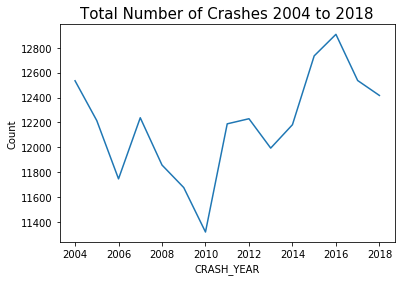

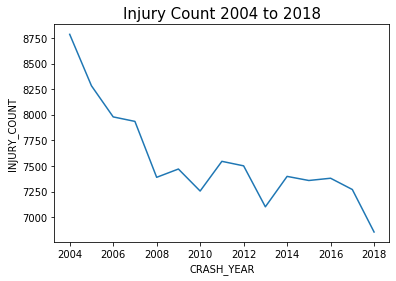

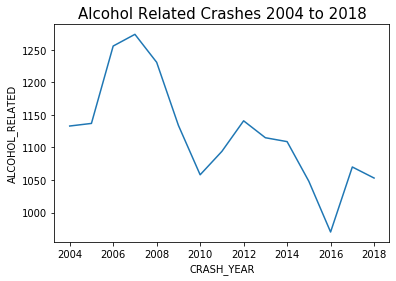

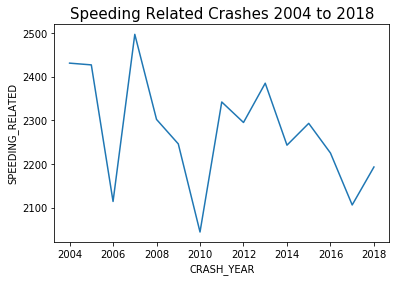

In [17]:
# total number of crashes over years
df = pd.DataFrame({'CRASH_YEAR': df_io['CRASH_YEAR'], 'Count': np.ones(len(df_io))})
df = df.groupby('CRASH_YEAR').count().reset_index()
sns.lineplot(x='CRASH_YEAR', y='Count', data=df).set_title('Total Number of Crashes 2004 to 2018', fontsize=15)

# total injuries count over years
plt.figure()
df = df_io.groupby('CRASH_YEAR').sum().reset_index()
sns.lineplot(x='CRASH_YEAR', y='INJURY_COUNT', data=df).set_title('Injury Count 2004 to 2018', fontsize=15)

# alcohol related crashing
plt.figure()
sns.lineplot(df['CRASH_YEAR'], df['ALCOHOL_RELATED']).set_title('Alcohol Related Crashes 2004 to 2018', fontsize=15)

# speeding related
plt.figure()
sns.lineplot(df['CRASH_YEAR'], df['SPEEDING_RELATED']).set_title('Speeding Related Crashes 2004 to 2018', fontsize=15)


### Car crash over months

Now we developed a general view of car crashing trend over years, we may also want to observe the effect of seasons and months. As shown in the figure below, the curve shows an interesting trend of having peaks in winter months and a minimum value in April. The difference between the maximum and the minimum is around 5000 number of incidents. One reason may be because of the winter snowy and icy condition of the road, which makes road slippery and therefore increase the possibility of car crashes. 

Text(0.5, 1.0, 'Total Number of Crashes by Month 2004 to 2018')

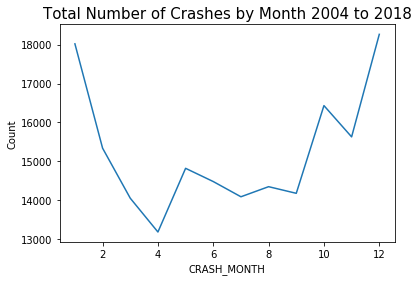

In [19]:
# crash by month
plt.figure()
df = pd.DataFrame({'CRASH_MONTH': df_io['CRASH_MONTH'], 'Count': np.ones(len(df_io))})
df = df.groupby('CRASH_MONTH').count().reset_index()
sns.lineplot(df['CRASH_MONTH'], df['Count']).set_title('Total Number of Crashes by Month 2004 to 2018', fontsize=15)

As the goal of this project is to analyze car crash severity level and understand the influece of different variables that may contribute to it, next, we will develop scatterplot matrices to visualize the affects of variables. The following two sections develop scatterplot matrix for, respectively, static and dynamic variables, which have been explained before. The response variable that we analyzed for in these two plots is max severity level, which have 7 categories. 

### Maximum severity level vs. environmental static factors

In the plot below, we visualized the relation between max severity level and road condition, lane closed condition, illumination and time of day when event happened. It has been observed that there's no apparent relationship between all other variables except illumination, and potentially lane closed condition. It is interesting, however, that the lane closed condition has a weak relation with illumination condition: in darker condition, the lane tend to be not closed. 

<Figure size 432x288 with 0 Axes>

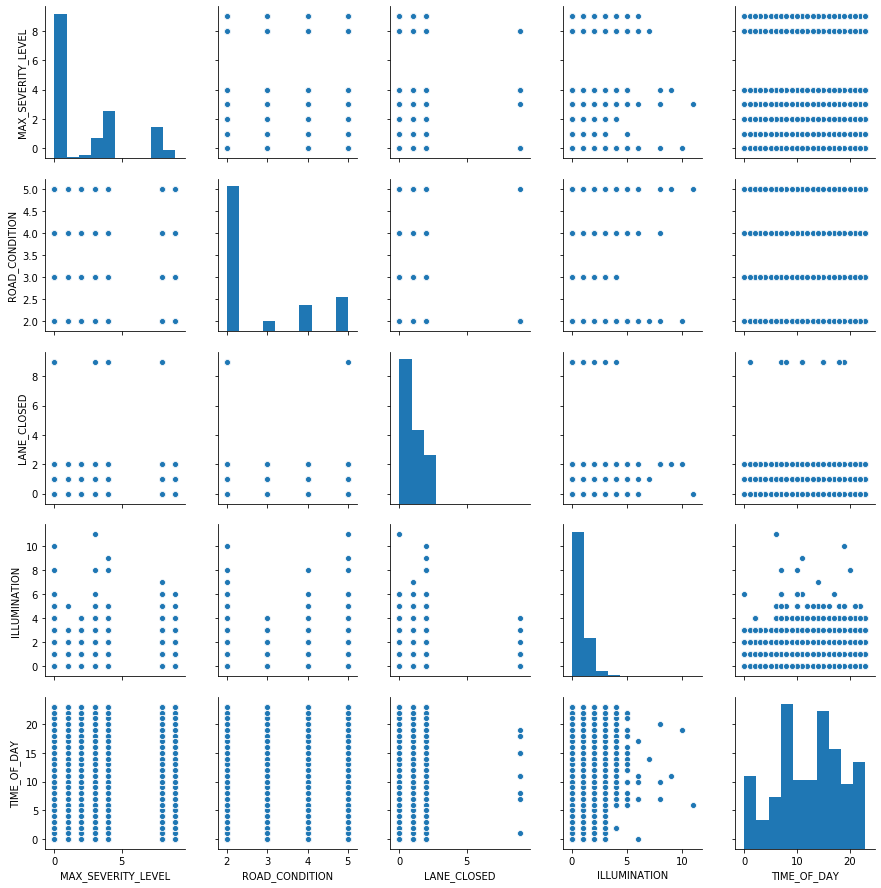

In [34]:
def scatterplot_matrix_static(metric):
    plt.figure()
    df = pd.DataFrame({metric: df_io[metric],
                       'ROAD_CONDITION': df_io['ROAD_CONDITION'],
                       'LANE_CLOSED': df_io['LANE_CLOSED'],
                       'ILLUMINATION': df_io['AUTOMOBILE_COUNT'],
                       'TIME_OF_DAY': df_io['TIME_OF_DAY'],
                      })
    sns.pairplot(df)

# scatterplot matrix to assess max severity level (static)
scatterplot_matrix_static('MAX_SEVERITY_LEVEL')

### Maximum severity level vs. dynamic factors

In the plot below, we visualized the relation between max severity level and heavy truck cound, automobile count and weather. Only automobile count shows a relation with max severity level, while all other variables do not, which is surprising as it is commonly believed that weather is related to car crash severity level. Weather, however, is related to automobile count, and the relation appears to be negative, which means that automobile on the road decreases across rain, sleet/hail, snow and fog. This is expected as fog condition decreases visibility the most. 

<Figure size 432x288 with 0 Axes>

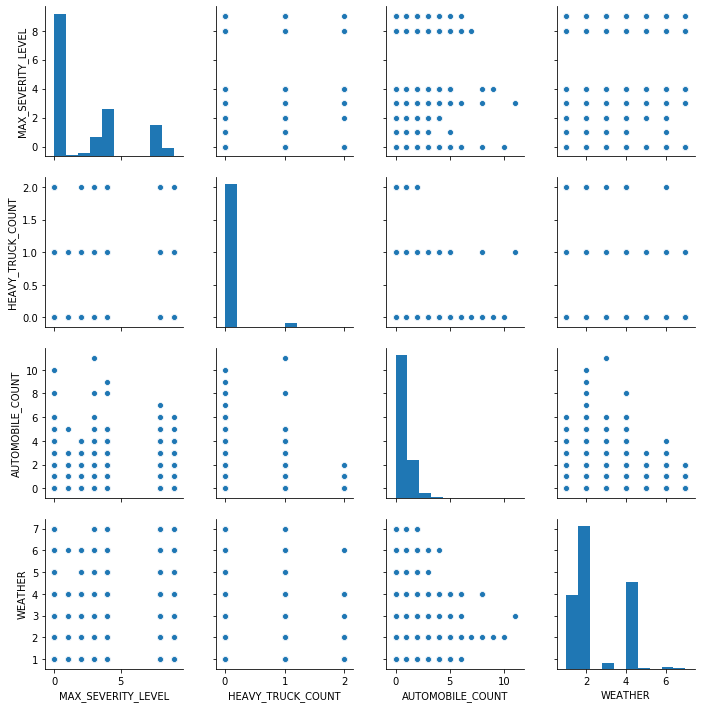

In [31]:
def scatterplot_matrix_dynamic(metric):
    plt.figure()
    df = pd.DataFrame({metric: df_io[metric],
                       'HEAVY_TRUCK_COUNT': df_io['HEAVY_TRUCK_COUNT'],
                       'AUTOMOBILE_COUNT': df_io['AUTOMOBILE_COUNT'],
                       'WEATHER': df_io['WEATHER'],
                      })
    sns.pairplot(df)

# scatterplot matrix to assess max severity level (static)
scatterplot_matrix_dynamic('MAX_SEVERITY_LEVEL')

### Data mapping over Allegheny County

Finally, we visualize car crashing severity on Allegheny county map. The following code section retrieves .shp file for the Allegheny county, constructs geopanda dataframe and plots the severity levels over the map using all 2004 to 2008 data. In the resulting figure, we may obseved that the area near Pittsburgh downtown is centered by data with unknown injury condition, whereas in all other areas, the severity level is reported as injuried by condition unknown.

Additionally, we observe that most of the data with report injury level only has minor injury or not injured. In this region, the events when people are killed are very rare. 

In [25]:
df = pd.DataFrame({'LONGITUDE': df_io['DEC_LONG'], 
                   'LATITUDE': df_io['DEC_LAT'], 
                   'MAX_SEVERITY_LEVEL': df_io['MAX_SEVERITY_LEVEL'], 
                   'YEAR': df_io['CRASH_YEAR'],
                   'MONTH': df_io['CRASH_MONTH']})
df = df.dropna().astype("float64")
df['YEAR'] = df['YEAR'].astype("int64")

#constrain to Pittsburgh map
df = df[df.LONGITUDE < -79.7]
df = df[df.LONGITUDE > -80.4]
df = df[df.LATITUDE < 40.65]
df = df[df.LATITUDE > 40.2]

geo = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry = geo)

In [26]:
# load map
if not Path('Allegheny_County_Addressing_Street_Centerlines.zip').exists():
    wget.download("http://openac-alcogis.opendata.arcgis.com/datasets/1e05bdc3703e4a48be4a5d72ce855d94_0.zip")

with zipfile.ZipFile("Allegheny_County_Addressing_Street_Centerlines.zip","r") as zip_ref:
    zip_ref.extractall("Allegheny_County_Addressing_Street_Centerlines")

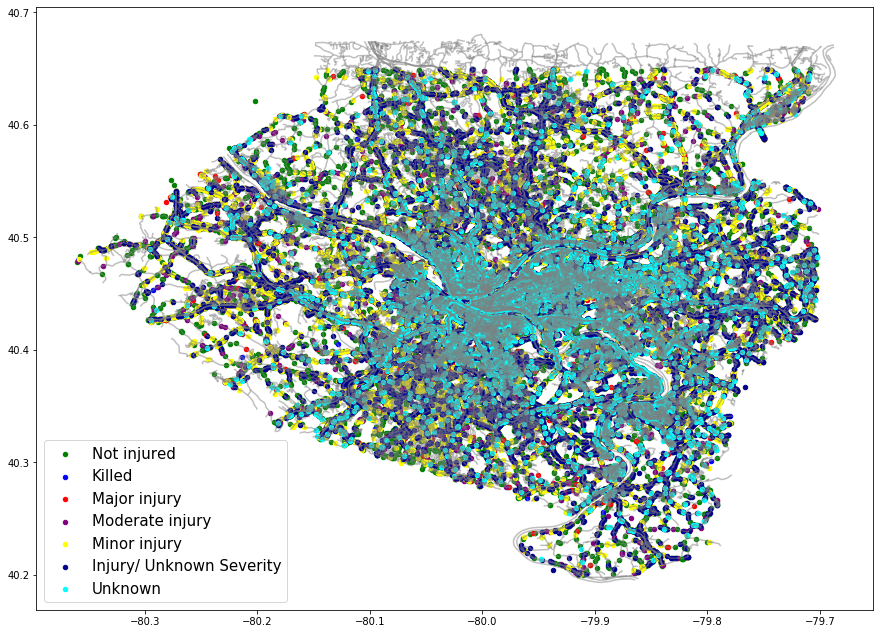

In [27]:
# plot cumulative
pitt_map = gpd.read_file('Allegheny_County_Addressing_Street_Centerlines/Allegheny_County_Addressing_Street_Centerlines.shp')
fig, ax = plt.subplots(figsize = (15, 15))
pitt_map.plot(ax = ax, color='grey', alpha=0.5)
ms = 20
geo_df[geo_df['MAX_SEVERITY_LEVEL'] == 0].plot(ax=ax, markersize=ms, color='green', marker='o', label='Not injured')
geo_df[geo_df['MAX_SEVERITY_LEVEL'] == 1].plot(ax=ax, markersize=ms, color='blue', marker='o', label='Killed')
geo_df[geo_df['MAX_SEVERITY_LEVEL'] == 2].plot(ax=ax, markersize=ms, color='red', marker='o', label='Major injury')
geo_df[geo_df['MAX_SEVERITY_LEVEL'] == 3].plot(ax=ax, markersize=ms, color='purple', marker='o', label='Moderate injury')
geo_df[geo_df['MAX_SEVERITY_LEVEL'] == 4].plot(ax=ax, markersize=ms, color='yellow', marker='o', label='Minor injury')
geo_df[geo_df['MAX_SEVERITY_LEVEL'] == 8].plot(ax=ax, markersize=ms, color='DarkBlue', marker='o', label='Injury/ Unknown Severity')
geo_df[geo_df['MAX_SEVERITY_LEVEL'] == 9].plot(ax=ax, markersize=ms, color='cyan', marker='o', label='Unknown')

plt.legend(prop={'size':15})

### Data mapping on Allegheny County over years

The following section generates a gif of the severity level map over 2004 to 2018. As observed before, the overall patterns in regions and levels do not have significant changes and winters have the most car crashes happen. The gif is pre-generated and uploaded with this jupyter notebook, thus may be imported directly. The for-loop generates all the maps and be used to generate gif using online resource for converting jps's to gif.

In [ ]:
#generates all maps (do not need to run)
ms = 50
pitt_map = gpd.read_file('Allegheny_County_Addressing_Street_Centerlines/Allegheny_County_Addressing_Street_Centerlines.shp')

for year in range(2016, 2019):
    for month in range(1, 13):
        df_month = geo_df[(geo_df['MONTH'] == month) & (geo_df['YEAR'] == year)]
        fig, ax = plt.subplots(figsize = (15, 15))
        pitt_map.plot(ax = ax, color='grey', alpha=0.5)
        
        df_month[df_month['MAX_SEVERITY_LEVEL'] == 0].plot(ax=ax, markersize=ms, facecolor='green', marker='o', label='Not injured')
        df_month[df_month['MAX_SEVERITY_LEVEL'] == 1].plot(ax=ax, markersize=ms, facecolor='blue', marker='o', label='Killed')
        df_month[df_month['MAX_SEVERITY_LEVEL'] == 2].plot(ax=ax, markersize=ms, facecolor='red', marker='o', label='Major injury')
        df_month[df_month['MAX_SEVERITY_LEVEL'] == 3].plot(ax=ax, markersize=ms, facecolor='purple', marker='o', label='Moderate injury')
        df_month[df_month['MAX_SEVERITY_LEVEL'] == 4].plot(ax=ax, markersize=ms, facecolor='yellow', marker='o', label='Minor injury')
        df_month[df_month['MAX_SEVERITY_LEVEL'] == 8].plot(ax=ax, markersize=ms, facecolor='DarkBlue', marker='o', label='Injury/ Unknown Severity')
        df_month[df_month['MAX_SEVERITY_LEVEL'] == 9].plot(ax=ax, markersize=ms, facecolor='cyan', marker='o', label='Unknown')
        
        plt.title(label='MAX_SEVERITY_LEVEL of '+str(year)+'.'+str(month), fontsize=20)
        fig = plt.legend(prop={'size':15}, loc=2).get_figure()
        
        fig.savefig('maps-over-time/'+str(year)+'-'+str(month)+'.jpg')
        print(str(year)+'-'+str(month)+' saved')

In [2]:
# pick an animated gif file you have in the working directory
ag_file = "map-over-year.gif"
animation = pyglet.resource.animation(ag_file)
sprite = pyglet.sprite.Sprite(animation)

# create a window and set it to the image size
win = pyglet.window.Window(width=sprite.width, height=sprite.height)

# set window background color = r, g, b, alpha
# each value goes from 0.0 to 1.0
green = 0, 1, 0, 1
pyglet.gl.glClearColor(*green)

@win.event
def on_draw():
    win.clear()
    sprite.draw()
    
pyglet.app.run()

## Data Cleanup

Before analysis, we drop out the unnecessary information that we do not need. 

In [38]:
# drop col that will not be used
for col in df_io.columns:
    if col not in static and col not in dynamic and col not in label:
        df_io.drop(col, axis = 1, inplace = True)

# drop rows contain nan
df_io = df_io.dropna()
df_io = df_io.astype("int64")
df_io[categorical] = df_io[categorical].astype("object")

# group data into dataset/label
df_data = df_io[combined].copy()
df_label = df_io[label].copy()
print(df_data.info(), '\n')
print(df_label.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43961 entries, 1 to 180963
Data columns (total 11 columns):
ROAD_CONDITION       43961 non-null object
LANE_CLOSED          43961 non-null object
TIME_OF_DAY          43961 non-null int64
SPEED_LIMIT          43961 non-null int64
ILLUMINATION         43961 non-null object
MOTORCYCLE_COUNT     43961 non-null int64
HEAVY_TRUCK_COUNT    43961 non-null int64
HAZARDOUS_TRUCK      43961 non-null object
AUTOMOBILE_COUNT     43961 non-null int64
SCH_BUS_IND          43961 non-null object
WEATHER              43961 non-null object
dtypes: int64(5), object(6)
memory usage: 4.0+ MB
None 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43961 entries, 1 to 180963
Data columns (total 5 columns):
PERSON_COUNT          43961 non-null int64
FATAL_COUNT           43961 non-null int64
INJURY_COUNT          43961 non-null int64
MAX_SEVERITY_LEVEL    43961 non-null int64
MAJOR_INJURY          43961 non-null int64
dtypes: int64(5)
memory usage: 2.0 MB
Non

## Training Model

Given that the features we want to predict are largely well indexed and discrete, and we also consider the features to be independent of each other and they are also either categorical or integer data, we think a Naive Bayes Classifier would be the best fit. Below we have supplied a working implementation for the Naive Bayes Classifier, as written for homework 4. 

In [12]:
class GaussianPredictor:
    
    """ Feature predictor for a normally distributed real-valued, continuous feature.

        attr:
            k : int -- number of classes
            mu : np.ndarray[k] -- vector containing per class mean of the feature
            sigma : np.ndarray[k] -- vector containing per class std. deviation of the feature
    """
    
    def __init__(self, k):
        """ constructor

        args : k -- number of classes
        """
        self.k = k
        self.mu = np.zeros(k)
        self.sigma = np.zeros(k)
        pass

    def fit(self, x, y):
        """update predictor statistics (mu, sigma) for Gaussian distribution

        args:
            x : pd.Series -- feature values
            y : np.Series -- class labels
            
        return : GaussianPredictor -- return self for convenience
        
        """
        y=np.array(y)
        x=np.array(x)
    
        for i in range(self.k):
            ybools = (y==i)
            given_i = np.extract(ybools,x)
            self.mu[i]=given_i.mean()
            self.sigma[i]=np.sqrt(given_i.var())
        return self
            
    def partial_log_likelihood(self, x):
        """ log likelihood of feature values x according to each class

        args:
            x : pd.Series -- feature values

        return: np.ndarray[self.k, len(x)] : log likelihood for this feature for each class
        """
        logpdfs = np.zeros((self.k,len(x)))
        for i in range(self.k):
            logpdfs[i]=stats.norm(loc=self.mu[i],scale=self.sigma[i]).logpdf(x)
        return logpdfs

In [13]:
class CategoricalPredictor:
    """ Feature predictor for a categorical feature.

        attr: 
            k : int -- number of classes
            p : Dict[feature_value, np.ndarray[k]] -- dictionary of vectors containing per-class probability of a feature value;
    """
    
    def __init__(self, k):
        """ constructor

        args : k -- number of classes
        """
        self.k=k

    def fit(self, x, y, alpha=1.):
        """ initializes the predictor statistics (p) for Categorical distribution
        
        args:
            x : pd.Series -- feature values
            y : pd.Series -- class labels
        
        kwargs:
            alpha : float -- smoothing factor

        return : CategoricalPredictor -- returns self for convenience:
        """
        y=np.array(y)
        x=np.array(x)
        self.p = {}
        for char in set(x):
            self.p[char]=np.zeros(self.k)
            
        
        for i in range(self.k):
            # n=sum([1 for j in range(len(y)) if y[j] == i])
            ybools= (y==i)
            
            n=np.sum( ybools )
            for char in set(x):
                xbools= (x == char)
                # nj=sum([1 for j in range(len(y)) if x[j] == char and y[j] == i ])
                nj = np.sum(np.logical_and(xbools,ybools))
                (self.p[char])[i] = (nj + alpha)/ (n+len(set(x))*alpha)
        return self

    def partial_log_likelihood(self, x):
        """ log likelihood of feature values x according to each class

        args:
            x : pd.Series -- vector of feature values

        return : np.ndarray[self.k, len(x)] -- matrix of log likelihood for this feature
        """
        like = np.zeros((self.k,len(x)))
        
        for i in range(self.k):
            for j,char in enumerate(x):
                like[i][j]=np.log(self.p[char][i])
        return like

In [14]:
# working
class NaiveBayesClassifier:
    """ Naive Bayes classifier for a mixture of continuous and categorical attributes.
        We use GaussianPredictor for continuous attributes and CategoricalPredictor for categorical ones.
        
        attr:
            predictor : Dict[column_name,model] -- model for each column
            log_prior : np.ndarray -- the (log) prior probability of each class
    """

    def __init__(self, df, label, alpha=1.):
        """initialize predictors for each feature and compute class prior
        
        args:
            df : pd.DataFrame -- processed dataframe, without any missing values.
        
        kwargs:
            alpha : float -- smoothing factor for prior probability
        """
        k = max(label)+1
        self.log_prior = np.zeros(k)
        n = len(label)
        for i in range(k):
            ybools= (label==i)          
            nt=np.sum( ybools )
            self.log_prior[i] = np.log( (nt+alpha)/(n+(k*alpha)))
        
        self.predictor = dict()
        types = dict(df.dtypes)
        for key in types:
            if key != "label" and key!= "index":
                if str(types[key])=="int64":
                    self.predictor[key]=GaussianPredictor(k).fit(df[key],label)
                elif str(types[key])=="object":
                    self.predictor[key]=CategoricalPredictor(k).fit(df[key],label)
                else:
                    raise TypeError
                    
        self.k=k            
        pass

    def log_likelihood(self, x):
        """log_likelihood for input instances from log_prior and partial_log_likelihood of feature predictors

        args:
            x : pd.DataFrame -- processed dataframe (ignore label if present)

        returns : np.ndarray[num_classes, len(x)] -- array of log-likelihood
        """
        like = np.array(([self.log_prior,]*len(x))).transpose()
        
        for key in self.predictor:
            model = self.predictor[key]
            z= model.partial_log_likelihood(x[key])
            like +=z
            
        return like           

    def predict(self, x):
        """predicts label for input instances, breaks ties in favor of the class with lower id.

        args:
            x : pd.DataFrame -- processed dataframe (ignore label if present)

        returns : np.ndarray[len(x)] -- vector of class labels
        """
        pred = np.argmax(self.log_likelihood(x),axis = 0)
        return pred


### Label normalization

Labels may not neccesarily be in a nice 0-k format to fit the model, so we construct a map to map it properly.

In [15]:
def label_normalization(label, label_test):
    labellist = pd.Series(np.append(label,label_test)).unique()
    labellist.sort()
    revdic = dict()
    for i,z in enumerate(labellist):
        revdic[z] = i
    f = (lambda s: revdic[s])
    return np.array(list(map(f, label))),np.array(list(map(f, label_test)))

### Accuracy estimate

We write some helper functions to calculate the accuracy of our models, and also the f1 score for those with only two labels, 0 and 1.

In [16]:
def cal_accuracy(y_pred, y_test):
    correct_counter = 0
    total = len(y_test)
    if total != len(y_pred):
        print("param size not match.")
        
    for idx in range(total):
        if (int)(y_pred[idx]) == (int)(y_test[idx]):
            correct_counter += 1
            
    return correct_counter / total

def f1(pred, ground):
    """ evaluates a classifier based on a supplied validation data

    args:
        pred: numpy.ndarray(bool) -- predictions
        ground: numpy.ndarray(bool) -- known ground-truth values
    
    return : double -- the F1 score of the predictions
    """
    pred = np.array(pred, dtype=bool)
    ground = np.array(ground, dtype=bool)
    realT = sum(ground)
    predT = sum(pred)
    bothT = float(sum([1 for i in range(ground.shape[0]) if pred[i] and ground[i]]))
    precision = bothT/predT
    recall = bothT/realT
    print("precision and recal in f1:", precision, recall)
    return 2*(precision*recall)/(precision+recall)

### Define a function to split, train, pred and test data

In [1]:
def train(data, label, s, verbal, a=1.):
    x_train, x_test, y_train, y_test = train_test_split(data, df_io[label], test_size=s, random_state=42)
    y_train, y_test = label_normalization(y_train, y_test)
    classifier = NaiveBayesClassifier(x_train, pd.Series(y_train), a)
    y_pred = classifier.predict(x_test)
    c = collections.Counter(y_pred)
    d = collections.Counter(y_test)
    
    if verbal:
        print(label, "pred counter: ", c)
        print(label, "test counter: ", d)
        print(label, "f1: ", f1(y_pred, y_test))
        
    a = cal_accuracy(y_pred, y_test)
    print(label, "accuracy: ", a, "\n~~~~~~~~~~")
    return (classifier, a)

In [20]:
def train_all(data, metrics, s, verbal=False):
    classifiers = []
    for (m, a) in metrics:
        classifier = train(data, m, s, verbal, a)
        classifiers.append(classifier)
        
    return classifiers

metrics = [('MAJOR_INJURY', 0.01),
           ('MAX_SEVERITY_LEVEL', 1.), 
           ('PERSON_COUNT', 1.), 
           ('FATAL_COUNT', 1.), 
           ('INJURY_COUNT', 0.001)
          ]
s = 0.33

print("******** train ENVIRONMENT STATIC factors **********")
classifier_s = train_all(df_io[static].copy(), metrics, s, True)

print("\n******** train DYNAMIC factors ********")
classifier_d = train_all(df_io[dynamic].copy(), metrics, s)

print("\n******** train COMBINED factors ********")
classifier_c = train_all(df_io[combined].copy(), metrics, s)


******** train ENVIRONMENT STATIC factors **********
MAJOR_INJURY pred counter:  Counter({0: 14508})
MAJOR_INJURY test counter:  Counter({0: 14287, 1: 221})
precision and recal in f1: nan 0.0
MAJOR_INJURY f1:  nan
MAJOR_INJURY accuracy:  0.9847670250896058 
~~~~~~~~~~


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


MAX_SEVERITY_LEVEL pred counter:  Counter({0: 14505, 4: 3})
MAX_SEVERITY_LEVEL test counter:  Counter({0: 8142, 4: 2714, 5: 1810, 3: 1105, 6: 454, 2: 213, 1: 70})
precision and recal in f1: 0.6666666666666666 0.00031416902293433867
MAX_SEVERITY_LEVEL f1:  0.0006280420788192808
MAX_SEVERITY_LEVEL accuracy:  0.561138682106424 
~~~~~~~~~~


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Degrees of freedom <= 0 for slice


PERSON_COUNT pred counter:  Counter({18: 14508})
PERSON_COUNT test counter:  Counter({1: 5318, 2: 4768, 3: 2342, 4: 1035, 5: 511, 6: 234, 7: 114, 8: 52, 0: 38, 9: 32, 10: 14, 12: 9, 11: 8, 15: 5, 13: 3, 16: 3, 14: 3, 20: 2, 21: 2, 48: 1, 28: 1, 26: 1, 19: 1, 46: 1, 34: 1, 17: 1, 25: 1, 45: 1, 31: 1, 44: 1, 18: 1, 30: 1, 40: 1, 24: 1})
precision and recal in f1: 0.9973807554452716 1.0
PERSON_COUNT f1:  0.998688660363034
PERSON_COUNT accuracy:  6.892748828232699e-05 
~~~~~~~~~~
FATAL_COUNT pred counter:  Counter({0: 14508})
FATAL_COUNT test counter:  Counter({0: 14437, 1: 66, 2: 5})
precision and recal in f1: nan 0.0
FATAL_COUNT f1:  nan
FATAL_COUNT accuracy:  0.9951061483319548 
~~~~~~~~~~
INJURY_COUNT pred counter:  Counter({9: 14508})
INJURY_COUNT test counter:  Counter({0: 8604, 1: 4431, 2: 1089, 3: 267, 4: 75, 5: 25, 6: 11, 9: 2, 10: 1, 8: 1, 11: 1, 7: 1})
precision and recal in f1: 0.40694789081885857 1.0
INJURY_COUNT f1:  0.5784832451499118
INJURY_COUNT accuracy:  0.00013785497656

In [21]:
# select the best classifier for each metric
classifiers = []
for i in range(0, len(metrics)):
    (c_s, a_s) = classifier_s[i]
    (c_d, a_d) = classifier_d[i]
    (c_c, a_c) = classifier_c[i]
    max_accuracy = max(a_s, a_d, a_c)
    if a_s == max_accuracy: classifiers.append((c_s, max_accuracy, 'static'))
    elif a_d == max_accuracy: classifiers.append((c_d, max_accuracy, 'dynamic'))
    else: classifiers.append((c_c, max_accuracy, 'combined'))
        
print(classifiers)

[(<__main__.NaiveBayesClassifier object at 0x124d83290>, 0.9847670250896058, 'static'), (<__main__.NaiveBayesClassifier object at 0x123b10a10>, 0.561138682106424, 'static'), (<__main__.NaiveBayesClassifier object at 0x126a7b750>, 0.0026192445547284257, 'dynamic'), (<__main__.NaiveBayesClassifier object at 0x10df91f90>, 0.9951061483319548, 'static'), (<__main__.NaiveBayesClassifier object at 0x137778890>, 0.005169561621174525, 'dynamic')]


## Pennsylvania-wise Comparison

Visualizing the max severity level distribution, we can see that car crashes happen more frequently in rural area and urbanized area than small urbanized area. However, among the three areas, the distribution of the max severity level shows a similar pattern: most car crashes were of max severity level 0 (no injury) or level and some were of level 3 or 4 (minor to moderate injury).

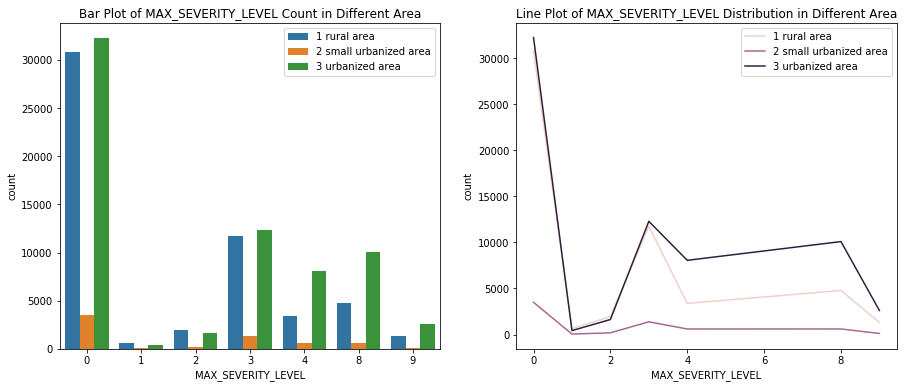

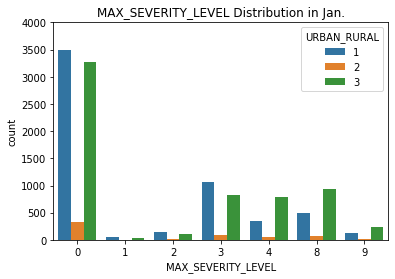

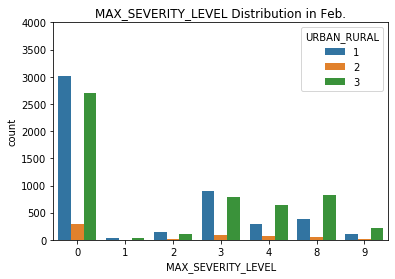

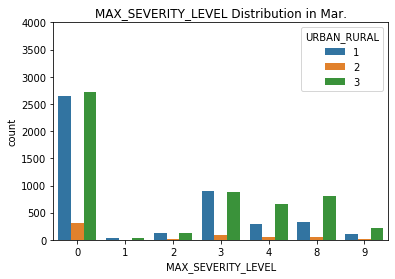

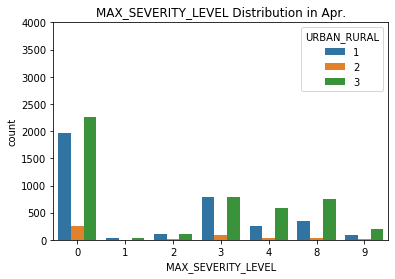

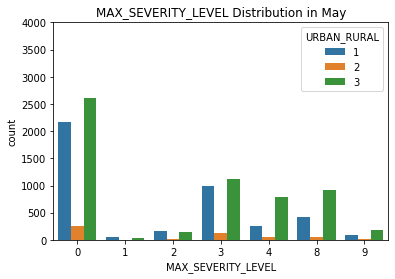

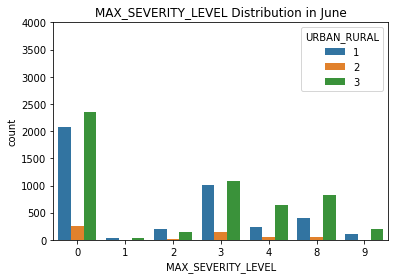

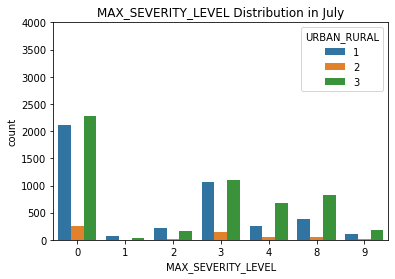

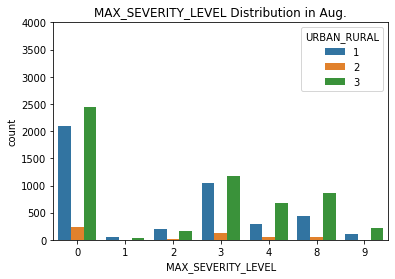

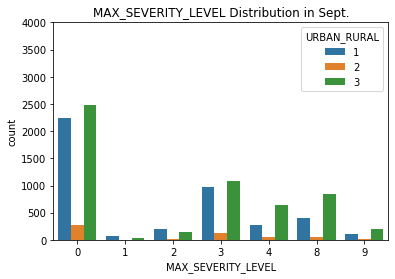

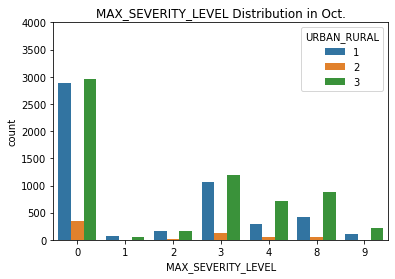

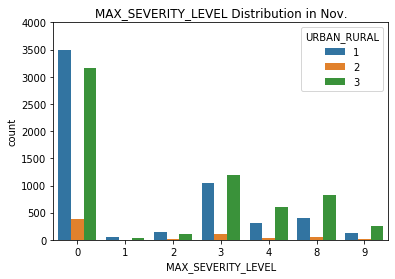

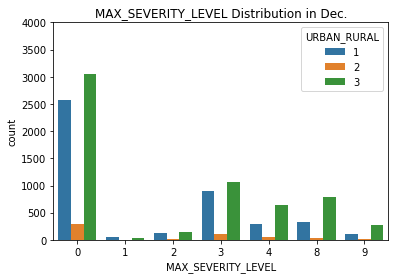

In [18]:
def urban_rural_comp():
    
    fig, img = plt.subplots(1, 2, figsize=(15, 6))
    pa = sns.countplot(x='MAX_SEVERITY_LEVEL', hue='URBAN_RURAL', data=df_counties, ax=img[0])
    pa.legend(labels=['1 rural area', '2 small urbanized area', '3 urbanized area'])
    pa.set(title="Bar Plot of MAX_SEVERITY_LEVEL Count in Different Area")
    
    
    df = pd.DataFrame({'MAX_SEVERITY_LEVEL': df_counties['MAX_SEVERITY_LEVEL'], 'URBAN_RURAL':df_counties['URBAN_RURAL'], 'count': np.ones(len(df_counties))})
    df = df.groupby(['MAX_SEVERITY_LEVEL','URBAN_RURAL']).count().reset_index()
    pb = sns.lineplot(x='MAX_SEVERITY_LEVEL', y='count', hue='URBAN_RURAL', data=df, ax=img[1])
    pb.legend(labels=['1 rural area', '2 small urbanized area', '3 urbanized area'])
    pb.set(title="Line Plot of MAX_SEVERITY_LEVEL Distribution in Different Area")
    
    num_to_month = {1:'Jan.', 2:'Feb.', 3:'Mar.', 4:'Apr.', 5:'May', 6:'June', 7:'July', 8:'Aug.', 9:'Sept.', 10:'Oct.', 11:'Nov.', 12:'Dec.'}
    for i in range(1,13):
        f = plt.figure(i+4)
        df = df_counties.loc[df_counties['CRASH_MONTH'] == i]
        p = sns.countplot(x='MAX_SEVERITY_LEVEL', hue='URBAN_RURAL', data=df)
        p.set(ylim=(0, 4000))
        ti = "MAX_SEVERITY_LEVEL Distribution in " + num_to_month[i]
        p.set(title=ti)
urban_rural_comp()

## Discussions on the Model

Although the accuracy of our model is high when predicting the MAJOR_INJURY and FATAL_COUNT, it fails to achieve a fair f1 score, indicating that our model is failing to have good precision and recall. We think this is because our most labels are skewed to one value. Taking the MAJOR_INJURY feature as example, we notice that over 97% of the data in the orignal dataset has the value 0 while the remaining are 1s (Fig. 3 below). Thus, our model is a lot more inclined to predict 0s over 1s, which gives rise to severe Type II errors. Considering its bad performance on the test set prediction, we decided not to use our model to do any further predictions. One possible fix is give higher weights on the minority labels or to choose a more balanced feature to use in the dataset.

Another consideration is that many of our features are categorical, but this lends no overall signal given to us by our chosen features. We has humans may be able to infer that slippery ice may cause collisions of greater magnitude, but this may only increase the probability of fatalities and injuries, and we cannot assign a pinpoint prediction, as the Naive Bayes Classfier attempts to do so. Things like major injuries or fatalities only happen with low probability even if the conditions are poor and many vehicles are involved, so the classifier will just have the maximum weight rest on "no major injuries" or "0 fatalities", as indeed that is what will happen most often.

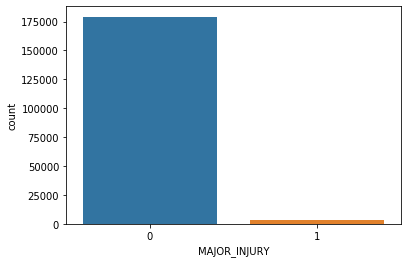

In [145]:
plt.figure(1)
mi = sns.countplot(x='MAJOR_INJURY', data=df_io)
mi.set(title="")

## Result and Conclusion

In this project, we built a Naive Bayes Model to predict the car crash severity. However, as the data was skewed towards no major injuries, low severity ,and a fatal count of 0, the bias made it difficult to predict when we would have high severity/injury/fatalities.

Although we did not use our model to do extra predictions, we discovered from the data visualization of the PennDOT Crash Download Map that rural and urbanized areas have more car crashes than small urbanized areas. Thus, these two types of areas also have more high severity crashes including severe injury or death. However, the severity level of the three areas follows a generally similar patter: no injury for most of the car crashes and minor to moderate injury for some of the remaining incidents. 

Based on the month analysis on the WPRDC dataset and the graphs from PennDOT Crash Download Map dataset, the winter months generally result in more car crashes and more severe incidents than other months.


## Future Work

Considering the bad performance of our prediction model, we think the next step might be collecting more balanced data to construct a predictive model, or removing such bias in the current model by increasing the weights on the minority labels. 

Future work can also focus on using a predictive model to predict which areas are more likely to have a car crash based on the static/dynamic conditions of theose areas. Also, people can analyze the geographic features of areas with car crashes, which can be included as a informative feature to add to the future predicting model. 



## Reference
PennDOT Crash Information Tool: https://crashinfo.penndot.gov/PCIT/welcome.html

PennDOT Public Crash Datasets: https://pennshare.maps.arcgis.com/apps/webappviewer/index.html?id=8fdbf046e36e41649bbfd9d7dd7c7e7e

WPRDC Alleghany County Crash Data: https://data.wprdc.org/dataset/allegheny-county-crash-data